In [1]:
##The feature engineering was redone starting from the original work and with extra work by us.

In [2]:

#updates:
#applied imputation into numerical and categorical data to improve the score by 0.327, now 0.9194



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

import gc
import os 

#print where those datasets are located 
from sklearn.preprocessing import minmax_scale
# from sklearn.cluster import KMeans

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


#df_trans = pd.read_csv('train_transaction.csv')
df_trans = pd.read_csv('train_transaction.csv',index_col='TransactionID')
df_test_trans = pd.read_csv('test_transaction.csv',index_col='TransactionID')

#record index of test datasets
test_trans_id = df_test_trans.index

#df_id = pd.read_csv('train_identity.csv')
df_id = pd.read_csv('train_identity.csv',index_col='TransactionID')
df_test_id = pd.read_csv('test_identity.csv',index_col='TransactionID')




sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')


In [3]:
def id_split(dataframe):
    
    #expand = split and expand to seperate column
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]
    
    #very specifically group device brands to help making decision
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #make the device name that are less than 200 to be other
    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    #new column to record that this device has id???
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [4]:
df_trans[df_trans['V326']==0]['isFraud']

TransactionID
2987004    0
2987008    0
2987016    0
2987017    0
2987022    0
          ..
3577465    0
3577495    0
3577506    0
3577526    1
3577531    0
Name: isFraud, Length: 72668, dtype: int64

In [5]:

#C sum feature
df_trans["C_sum"] = df_trans.loc[:,'C1':'C14'].sum(axis = 1).astype(np.int8)
df_test_trans["C_sum"] = df_test_trans.loc[:,'C1':'C14'].sum(axis = 1).astype(np.int8)

    
##D1 - D15
df_trans['D_na'] =df_trans.loc[:,'D1':'D14'].isna().sum(axis=1).astype(np.int8)
df_test_trans['D_na'] =df_test_trans.loc[:,'D1':'D14'].isna().sum(axis=1).astype(np.int8)

    
##M1-9
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

df_trans['M_na'] = df_trans[i_cols].isna().sum(axis=1).astype(np.int8)
df_test_trans['M_na'] = df_test_trans[i_cols].isna().sum(axis=1).astype(np.int8)


    
##V_ features
df_trans['V_na'] =df_trans.loc[:,"V1":"V339"].isna().sum(axis=1).astype(np.int8)
df_test_trans['V_na'] =df_test_trans.loc[:,"V1":"V339"].isna().sum(axis=1).astype(np.int8)

##ids 
df_id['id_na'] = df_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)
df_test_id['id_na'] = df_test_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)




In [6]:
df_id = id_split(df_id)
df_test_id = id_split(df_test_id)

In [7]:

##do not need to include right_index
df_train = df_trans.merge(df_id, how='left', left_index=True,  on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, on='TransactionID')

#add total na for train and test data. 
df_train['tot_na'] = df_train.isna().sum(axis=1).astype(np.int8) 
df_test['tot_na'] = df_test.isna().sum(axis=1).astype(np.int8)

print(df_train.head())
print(df_test.head())


# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id
gc.collect()



df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
##Deal with missing data



               isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  device_name  \
TransactionID                                    ...                
2987000        150.0    discover  142.0  credit  ...          NaN   
2987001        150.0  mastercard  102.0  credit  ...          NaN   
2987002        150.0        visa  166.0   debit  ...          NaN   
2987003        150.0  mastercard  117.0   debit  ...          NaN   
2987004        150

In [8]:
#https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm#
#removed V300 feature
useful_features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1',  'C5', 'C6', 'C9', 'C13',
                    'D1', 'D2', 'D3', 'D4', 'D5',  'D8', 'D9', 'D10', 'D11', 'D15', 
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9',  'V99', 'V100', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294','id_01',
                   'id_02', 'id_03','id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id','tot_na','C_sum','D_na','M_na','V_na','id_na']
print(len(useful_features))

187


In [9]:
cols_to_drop = [col for col in df_train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')

In [10]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [11]:
#added card6 - debit credit
columns_a = ['TransactionAmt', 'id_02', 'D15']
columns_b = ['card1', 'card4', 'addr1','card2']

for col_a in columns_a:
    for col_b in columns_b:
        for df in [df_train, df_test]:
            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

In [12]:
# New feature - log of transaction amount.
df_train['TransactionAmt_Log'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt_Log'] = np.log(df_test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
df_train['TransactionAmt_decimal'] = ((df_train['TransactionAmt'] - df_train['TransactionAmt'].astype(int)) * 1000).astype(int)
df_test['TransactionAmt_decimal'] = ((df_test['TransactionAmt'] - df_test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
df_train['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
df_test['Transaction_day_of_week'] = np.floor((df_test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
df_train['Transaction_hour'] = np.floor(df_train['TransactionDT'] / 3600) % 24
df_test['Transaction_hour'] = np.floor(df_test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in [ 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C1', 
                'card2__dist1', 'card1__card5','card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    df_train[feature] = df_train[f1].astype(str) + '_' + df_train[f2].astype(str)
    df_test[feature] = df_test[f1].astype(str) + '_' + df_test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(df_train[feature].astype(str).values) + list(df_test[feature].astype(str).values))
    df_train[feature] = le.transform(list(df_train[feature].astype(str).values))
    df_test[feature] = le.transform(list(df_test[feature].astype(str).values))
    


# Encoding - count encoding for both df_train and df_test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']:
    df_train[feature + '_count_full'] = df_train[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))
    df_test[feature + '_count_full'] = df_test[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))

In [13]:
df_train = df_train.reset_index()
df_train

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,...,card2__dist1,card1__card5,card5__P_emaildomain,addr1__card1,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full
0,2987000,0,86400,68.500000,13926,NaN,150.0,discover,142.0,credit,...,30942,4648,508,29248,56,17587,956845,9524,309,267648
1,2987001,0,86401,29.000000,2755,404.0,150.0,mastercard,102.0,credit,...,18042,10936,43,32205,1338,5593,956845,347386,49491,267648
2,2987002,0,86469,59.000000,4663,490.0,150.0,visa,166.0,debit,...,22906,12999,750,35560,1794,70496,956845,719649,102930,824959
3,2987003,0,86499,50.000000,18132,567.0,150.0,mastercard,117.0,debit,...,29266,9636,170,47566,7635,11287,956845,347386,47061,824959
4,2987004,0,86506,50.000000,4497,514.0,150.0,mastercard,102.0,credit,...,25382,12822,43,40560,30,27225,956845,347386,49491,267648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,6550,NaN,150.0,visa,226.0,debit,...,31114,15048,1391,23935,2110,17587,956845,719649,553537,824959
590536,3577536,0,15811049,39.500000,10444,225.0,150.0,mastercard,224.0,debit,...,8355,522,1312,11696,25,13274,956845,347386,153109,824959
590537,3577537,0,15811079,30.953125,12037,595.0,150.0,mastercard,224.0,debit,...,30628,2410,1312,17483,1373,1432,956845,347386,153109,824959
590538,3577538,0,15811088,117.000000,7826,481.0,150.0,mastercard,224.0,debit,...,21985,16445,1298,39726,5021,10151,956845,347386,153109,824959


In [14]:

#k fold cross validation target mean coding to avoid overfitting

N_SPLITS = 5
SEED = 6

folds = KFold(n_splits=N_SPLITS,shuffle = False, random_state=SEED)
# Test Data and expport DF
  
score = 0
y_result = 0

mean_of_target = df_train['isFraud'].mean()

target_mean_list =['card1','card2','addr1','addr1__card1','card1__card5','card5__P_emaildomain','id_02__D8']

# kfold target mean encoding for regularisation

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    print('Fold:',fold_+1)
    tr_x = df_train.iloc[trn_idx,:] 
    vl_x = df_train.iloc[val_idx,:]  
    
    for col in target_mean_list:
        print(col)
        df_train.loc[val_idx,f'{col}_target_enc'] = vl_x[col].map(tr_x.groupby(col)['isFraud'].mean())
        
        df_train[f'{col}_target_enc'].fillna(mean_of_target, inplace = True)
                                                        
for col in target_mean_list:
                                                            
    df_test[f'{col}_target_enc'] = df_test[col].map(df_train.groupby(col)[f'{col}_target_enc'].mean())

    df_test[f'{col}_target_enc'].fillna(mean_of_target, inplace = True)

    
    

Fold: 1
card1
card2
addr1
addr1__card1
card1__card5
card5__P_emaildomain
id_02__D8
Fold: 2
card1
card2
addr1
addr1__card1
card1__card5
card5__P_emaildomain
id_02__D8
Fold: 3
card1
card2
addr1
addr1__card1
card1__card5
card5__P_emaildomain
id_02__D8
Fold: 4
card1
card2
addr1
addr1__card1
card1__card5
card5__P_emaildomain
id_02__D8
Fold: 5
card1
card2
addr1
addr1__card1
card1__card5
card5__P_emaildomain
id_02__D8


In [15]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)



In [16]:
#label encoding the rest 
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))

In [17]:
#why sort ??
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']

X_test = df_test.drop(['TransactionDT'], axis=1)

del df_train, df_test
gc.collect()

20

In [18]:
X_train

,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,...,card6_count_full,card1_target_enc,card2_target_enc,addr1_target_enc,addr1__card1_target_enc,card1__card5_target_enc,card5__P_emaildomain_target_enc,id_02__D8_target_enc,P_emaildomain_bin,R_emaildomain_bin
0,68.500000,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,...,267648,0.277778,0.034990,0.017252,0.000000,0.277778,0.027027,0.021315,6,6
1,29.000000,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,...,267648,0.048598,0.070481,0.025970,0.000000,0.049057,0.103321,0.021315,4,6
2,59.000000,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,...,824959,0.008351,0.025021,0.036405,0.000000,0.008386,0.007018,0.021315,5,6
3,50.000000,18132,567.0,150.0,2,117.0,2,476.0,87.0,NaN,...,824959,0.014076,0.018022,0.033533,0.043716,0.014125,0.006798,0.021315,9,6
4,50.000000,4497,514.0,150.0,2,102.0,1,420.0,87.0,NaN,...,267648,0.062500,0.054766,0.032210,0.034990,0.062500,0.103321,0.034990,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.000000,6550,NaN,150.0,4,226.0,2,272.0,87.0,48.0,...,824959,0.002291,0.034990,0.028360,0.000000,0.002294,0.031258,0.021319,6,6
590536,39.500000,10444,225.0,150.0,2,224.0,2,204.0,87.0,NaN,...,824959,0.000000,0.032505,0.027308,0.000000,0.000000,0.050498,0.021319,4,6
590537,30.953125,12037,595.0,150.0,2,224.0,2,231.0,87.0,NaN,...,824959,0.020906,0.019544,0.031626,0.028777,0.020906,0.050498,0.021319,4,6
590538,117.000000,7826,481.0,150.0,2,224.0,2,387.0,87.0,3.0,...,824959,0.021204,0.035276,0.019689,0.022690,0.021231,0.035025,0.021319,0,6


In [19]:
from sklearn.model_selection import KFold
import lightgbm as lgb
##The following will carry out automated parameters optimisation for mainly accuray and overfitting related parameters based on Bayesian optimisation
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics





In [20]:
##Those parameters are the optimised ones for 4 hours 
#small min_data, large min_leaves, small learning rate, gbdt. 
#https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again
best_param = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [21]:
cate_list = ['id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38']

In [22]:
N_SPLITS = 5
SEED = 6

columns = X_train.columns
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

folds = KFold(n_splits=N_SPLITS, random_state=SEED)
# Test Data and expport DF
  
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score = 0
y_result = 0
print("running")
# use stratified fold to ensure the split datasets have same portion of postive and negative data.
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X_train.iloc[trn_idx,:], y_train.iloc[trn_idx]    
    vl_x, v_y = X_train.iloc[val_idx,:], y_train.iloc[val_idx]    
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(vl_x, label=v_y )  
        
    #this will run very slow. 
    num_round =5000
        
    #here valid sets are the criteria for stopping, when the auc score for valid sets do not improve after num_round, then it will stop. 
    estimator = lgb.train(
            best_param,
            train_data, 
            num_round,
            valid_sets = [train_data,valid_data],
            #print evaluation at each step
            verbose_eval = 10,
            )

    y_pred_valid = estimator.predict(vl_x)
    y_oof[val_idx] = y_pred_valid
    print(f"Fold {fold_ + 1} | AUC: {roc_auc_score(v_y, y_pred_valid)}")
    
    #score is the roc_auc of valid pred 
    score += roc_auc_score(v_y, y_pred_valid) / N_SPLITS
    y_result += estimator.predict(X_test) / N_SPLITS
    # we are not sure what fold is best for us
    # so we will average prediction results 
    # over folds; meaning each fold we predict test data and then get average.
    
    feature_importances[f'fold_{fold_ + 1}'] = estimator.feature_importance()

    del train_data, valid_data
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")
    #print('LOG loss', metrics.log_loss(RESULTS['isFraud'], RESULTS['stratifiedkfold']))


running
Fold: 1


c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.920244	valid_1's auc: 0.874366
[20]	training's auc: 0.927411	valid_1's auc: 0.876498
[30]	training's auc: 0.931618	valid_1's auc: 0.87721
[40]	training's auc: 0.935442	valid_1's auc: 0.878422
[50]	training's auc: 0.937986	valid_1's auc: 0.879285
[60]	training's auc: 0.942076	valid_1's auc: 0.880403
[70]	training's auc: 0.945264	valid_1's auc: 0.881929
[80]	training's auc: 0.948373	valid_1's auc: 0.882376
[90]	training's auc: 0.950918	valid_1's auc: 0.883383
[100]	training's auc: 0.953151	valid_1's auc: 0.884315
[110]	training's auc: 0.955255	valid_1's auc: 0.885305
[120]	training's auc: 0.957324	valid_1's auc: 0.885932
[130]	training's auc: 0.959657	valid_1's auc: 0.886293
[140]	training's auc: 0.961422	valid_1's auc: 0.886861
[150]	training's auc: 0.963251	valid_1's auc: 0.887327
[160]	training's auc: 0.964837	valid_1's auc: 0.888136
[170]	training's auc: 0.966706	valid_1's auc: 0.8884
[180]	training

[1490]	training's auc: 0.999957	valid_1's auc: 0.909556
[1500]	training's auc: 0.999959	valid_1's auc: 0.909636
[1510]	training's auc: 0.999962	valid_1's auc: 0.909641
[1520]	training's auc: 0.999964	valid_1's auc: 0.90967
[1530]	training's auc: 0.999965	valid_1's auc: 0.909789
[1540]	training's auc: 0.999967	valid_1's auc: 0.909828
[1550]	training's auc: 0.999969	valid_1's auc: 0.909775
[1560]	training's auc: 0.999971	valid_1's auc: 0.909812
[1570]	training's auc: 0.999972	valid_1's auc: 0.909834
[1580]	training's auc: 0.999974	valid_1's auc: 0.909859
[1590]	training's auc: 0.999975	valid_1's auc: 0.909931
[1600]	training's auc: 0.999976	valid_1's auc: 0.909903
[1610]	training's auc: 0.999978	valid_1's auc: 0.909899
[1620]	training's auc: 0.999979	valid_1's auc: 0.910012
[1630]	training's auc: 0.99998	valid_1's auc: 0.910061
[1640]	training's auc: 0.999982	valid_1's auc: 0.910043
[1650]	training's auc: 0.999983	valid_1's auc: 0.91003
[1660]	training's auc: 0.999984	valid_1's auc: 0.91

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.91722	valid_1's auc: 0.902222
[20]	training's auc: 0.924348	valid_1's auc: 0.904456
[30]	training's auc: 0.927707	valid_1's auc: 0.905604
[40]	training's auc: 0.931576	valid_1's auc: 0.906819
[50]	training's auc: 0.935412	valid_1's auc: 0.908154
[60]	training's auc: 0.939609	valid_1's auc: 0.909791
[70]	training's auc: 0.942943	valid_1's auc: 0.910589
[80]	training's auc: 0.946103	valid_1's auc: 0.911793
[90]	training's auc: 0.948642	valid_1's auc: 0.912903
[100]	training's auc: 0.951177	valid_1's auc: 0.9136
[110]	training's auc: 0.95338	valid_1's auc: 0.915007
[120]	training's auc: 0.955432	valid_1's auc: 0.915626
[130]	training's auc: 0.957642	valid_1's auc: 0.916265
[140]	training's auc: 0.959562	valid_1's auc: 0.917208
[150]	training's auc: 0.961389	valid_1's auc: 0.917909
[160]	training's auc: 0.963232	valid_1's auc: 0.918586
[170]	training's auc: 0.964977	valid_1's auc: 0.919025
[180]	training'

[1490]	training's auc: 0.999979	valid_1's auc: 0.935521
[1500]	training's auc: 0.99998	valid_1's auc: 0.935502
[1510]	training's auc: 0.999981	valid_1's auc: 0.93548
[1520]	training's auc: 0.999983	valid_1's auc: 0.935486
[1530]	training's auc: 0.999984	valid_1's auc: 0.935492
[1540]	training's auc: 0.999985	valid_1's auc: 0.935518
[1550]	training's auc: 0.999986	valid_1's auc: 0.935547
Early stopping, best iteration is:
[1454]	training's auc: 0.999974	valid_1's auc: 0.935618
Fold 2 | AUC: 0.9356176608108234
Fold: 3


c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.917363	valid_1's auc: 0.900185
[20]	training's auc: 0.922868	valid_1's auc: 0.902854
[30]	training's auc: 0.926709	valid_1's auc: 0.905057
[40]	training's auc: 0.93043	valid_1's auc: 0.907299
[50]	training's auc: 0.934351	valid_1's auc: 0.908749
[60]	training's auc: 0.939892	valid_1's auc: 0.911193
[70]	training's auc: 0.943325	valid_1's auc: 0.912609
[80]	training's auc: 0.946429	valid_1's auc: 0.913874
[90]	training's auc: 0.949081	valid_1's auc: 0.914955
[100]	training's auc: 0.951787	valid_1's auc: 0.916709
[110]	training's auc: 0.954355	valid_1's auc: 0.917893
[120]	training's auc: 0.956641	valid_1's auc: 0.918774
[130]	training's auc: 0.959048	valid_1's auc: 0.92001
[140]	training's auc: 0.961369	valid_1's auc: 0.920944
[150]	training's auc: 0.963094	valid_1's auc: 0.921872
[160]	training's auc: 0.96483	valid_1's auc: 0.92232
[170]	training's auc: 0.966849	valid_1's auc: 0.922798
[180]	training'

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.912993	valid_1's auc: 0.914817
[20]	training's auc: 0.919854	valid_1's auc: 0.918803
[30]	training's auc: 0.923915	valid_1's auc: 0.920877
[40]	training's auc: 0.928052	valid_1's auc: 0.922674
[50]	training's auc: 0.931497	valid_1's auc: 0.924883
[60]	training's auc: 0.937066	valid_1's auc: 0.926653
[70]	training's auc: 0.940594	valid_1's auc: 0.927956
[80]	training's auc: 0.943312	valid_1's auc: 0.929248
[90]	training's auc: 0.94617	valid_1's auc: 0.930646
[100]	training's auc: 0.948985	valid_1's auc: 0.931895
[110]	training's auc: 0.951718	valid_1's auc: 0.933064
[120]	training's auc: 0.953953	valid_1's auc: 0.933734
[130]	training's auc: 0.955911	valid_1's auc: 0.934668
[140]	training's auc: 0.957983	valid_1's auc: 0.935744
[150]	training's auc: 0.960127	valid_1's auc: 0.936931
[160]	training's auc: 0.962391	valid_1's auc: 0.937591
[170]	training's auc: 0.964619	valid_1's auc: 0.938212
[180]	traini

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.919273	valid_1's auc: 0.88946
[20]	training's auc: 0.925909	valid_1's auc: 0.895009
[30]	training's auc: 0.929868	valid_1's auc: 0.897954
[40]	training's auc: 0.934192	valid_1's auc: 0.900695
[50]	training's auc: 0.937322	valid_1's auc: 0.903034
[60]	training's auc: 0.94164	valid_1's auc: 0.904313
[70]	training's auc: 0.944489	valid_1's auc: 0.905123
[80]	training's auc: 0.947003	valid_1's auc: 0.906344
[90]	training's auc: 0.949213	valid_1's auc: 0.907095
[100]	training's auc: 0.951467	valid_1's auc: 0.908308
[110]	training's auc: 0.953879	valid_1's auc: 0.908821
[120]	training's auc: 0.95567	valid_1's auc: 0.909456
[130]	training's auc: 0.957688	valid_1's auc: 0.910766
[140]	training's auc: 0.959439	valid_1's auc: 0.911888
[150]	training's auc: 0.960991	valid_1's auc: 0.912516
[160]	training's auc: 0.962612	valid_1's auc: 0.912909
[170]	training's auc: 0.964465	valid_1's auc: 0.913546
[180]	training

In [23]:
##trick here 
##for oof = 0.93547, LB score is 0.9458
##for oof = 0.936, LB score is 0.945

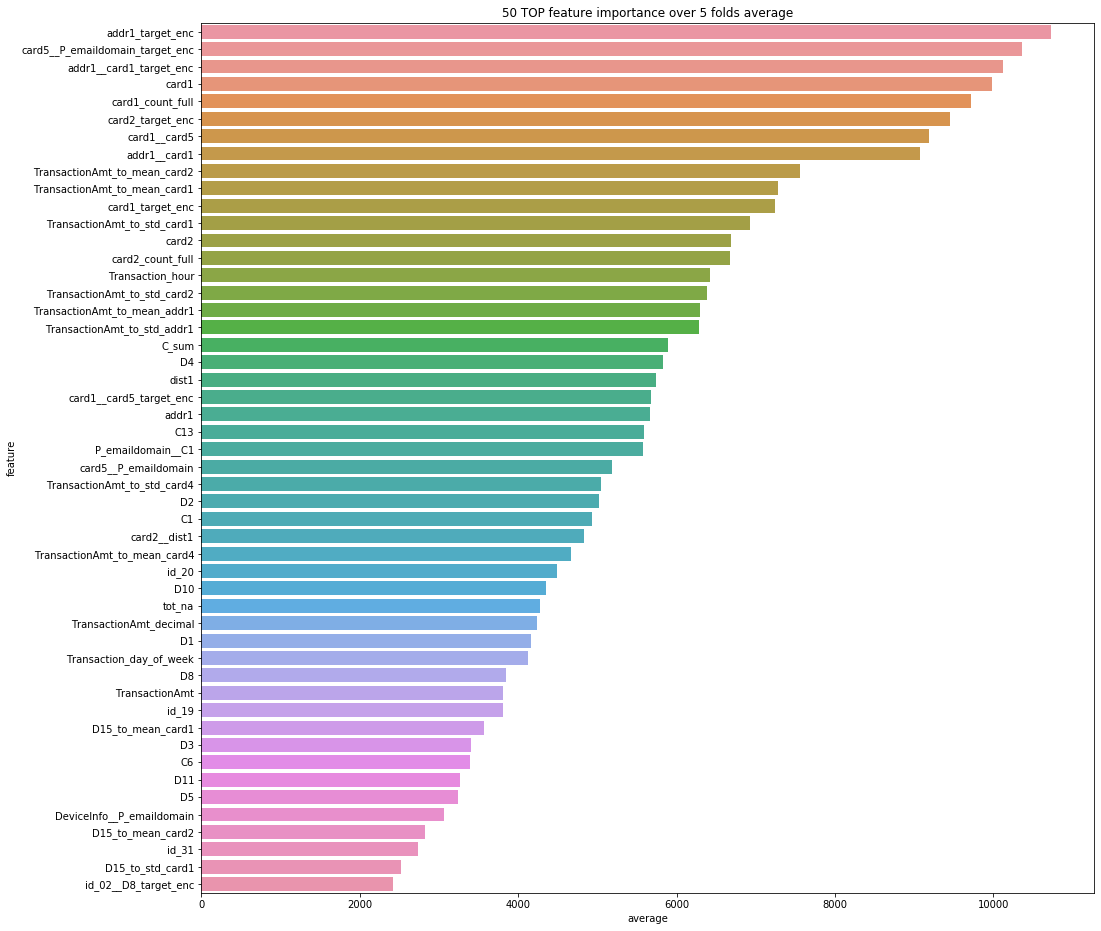

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
##take the mean of each feature importance of all folds. 
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [25]:
len(y_result)

506691

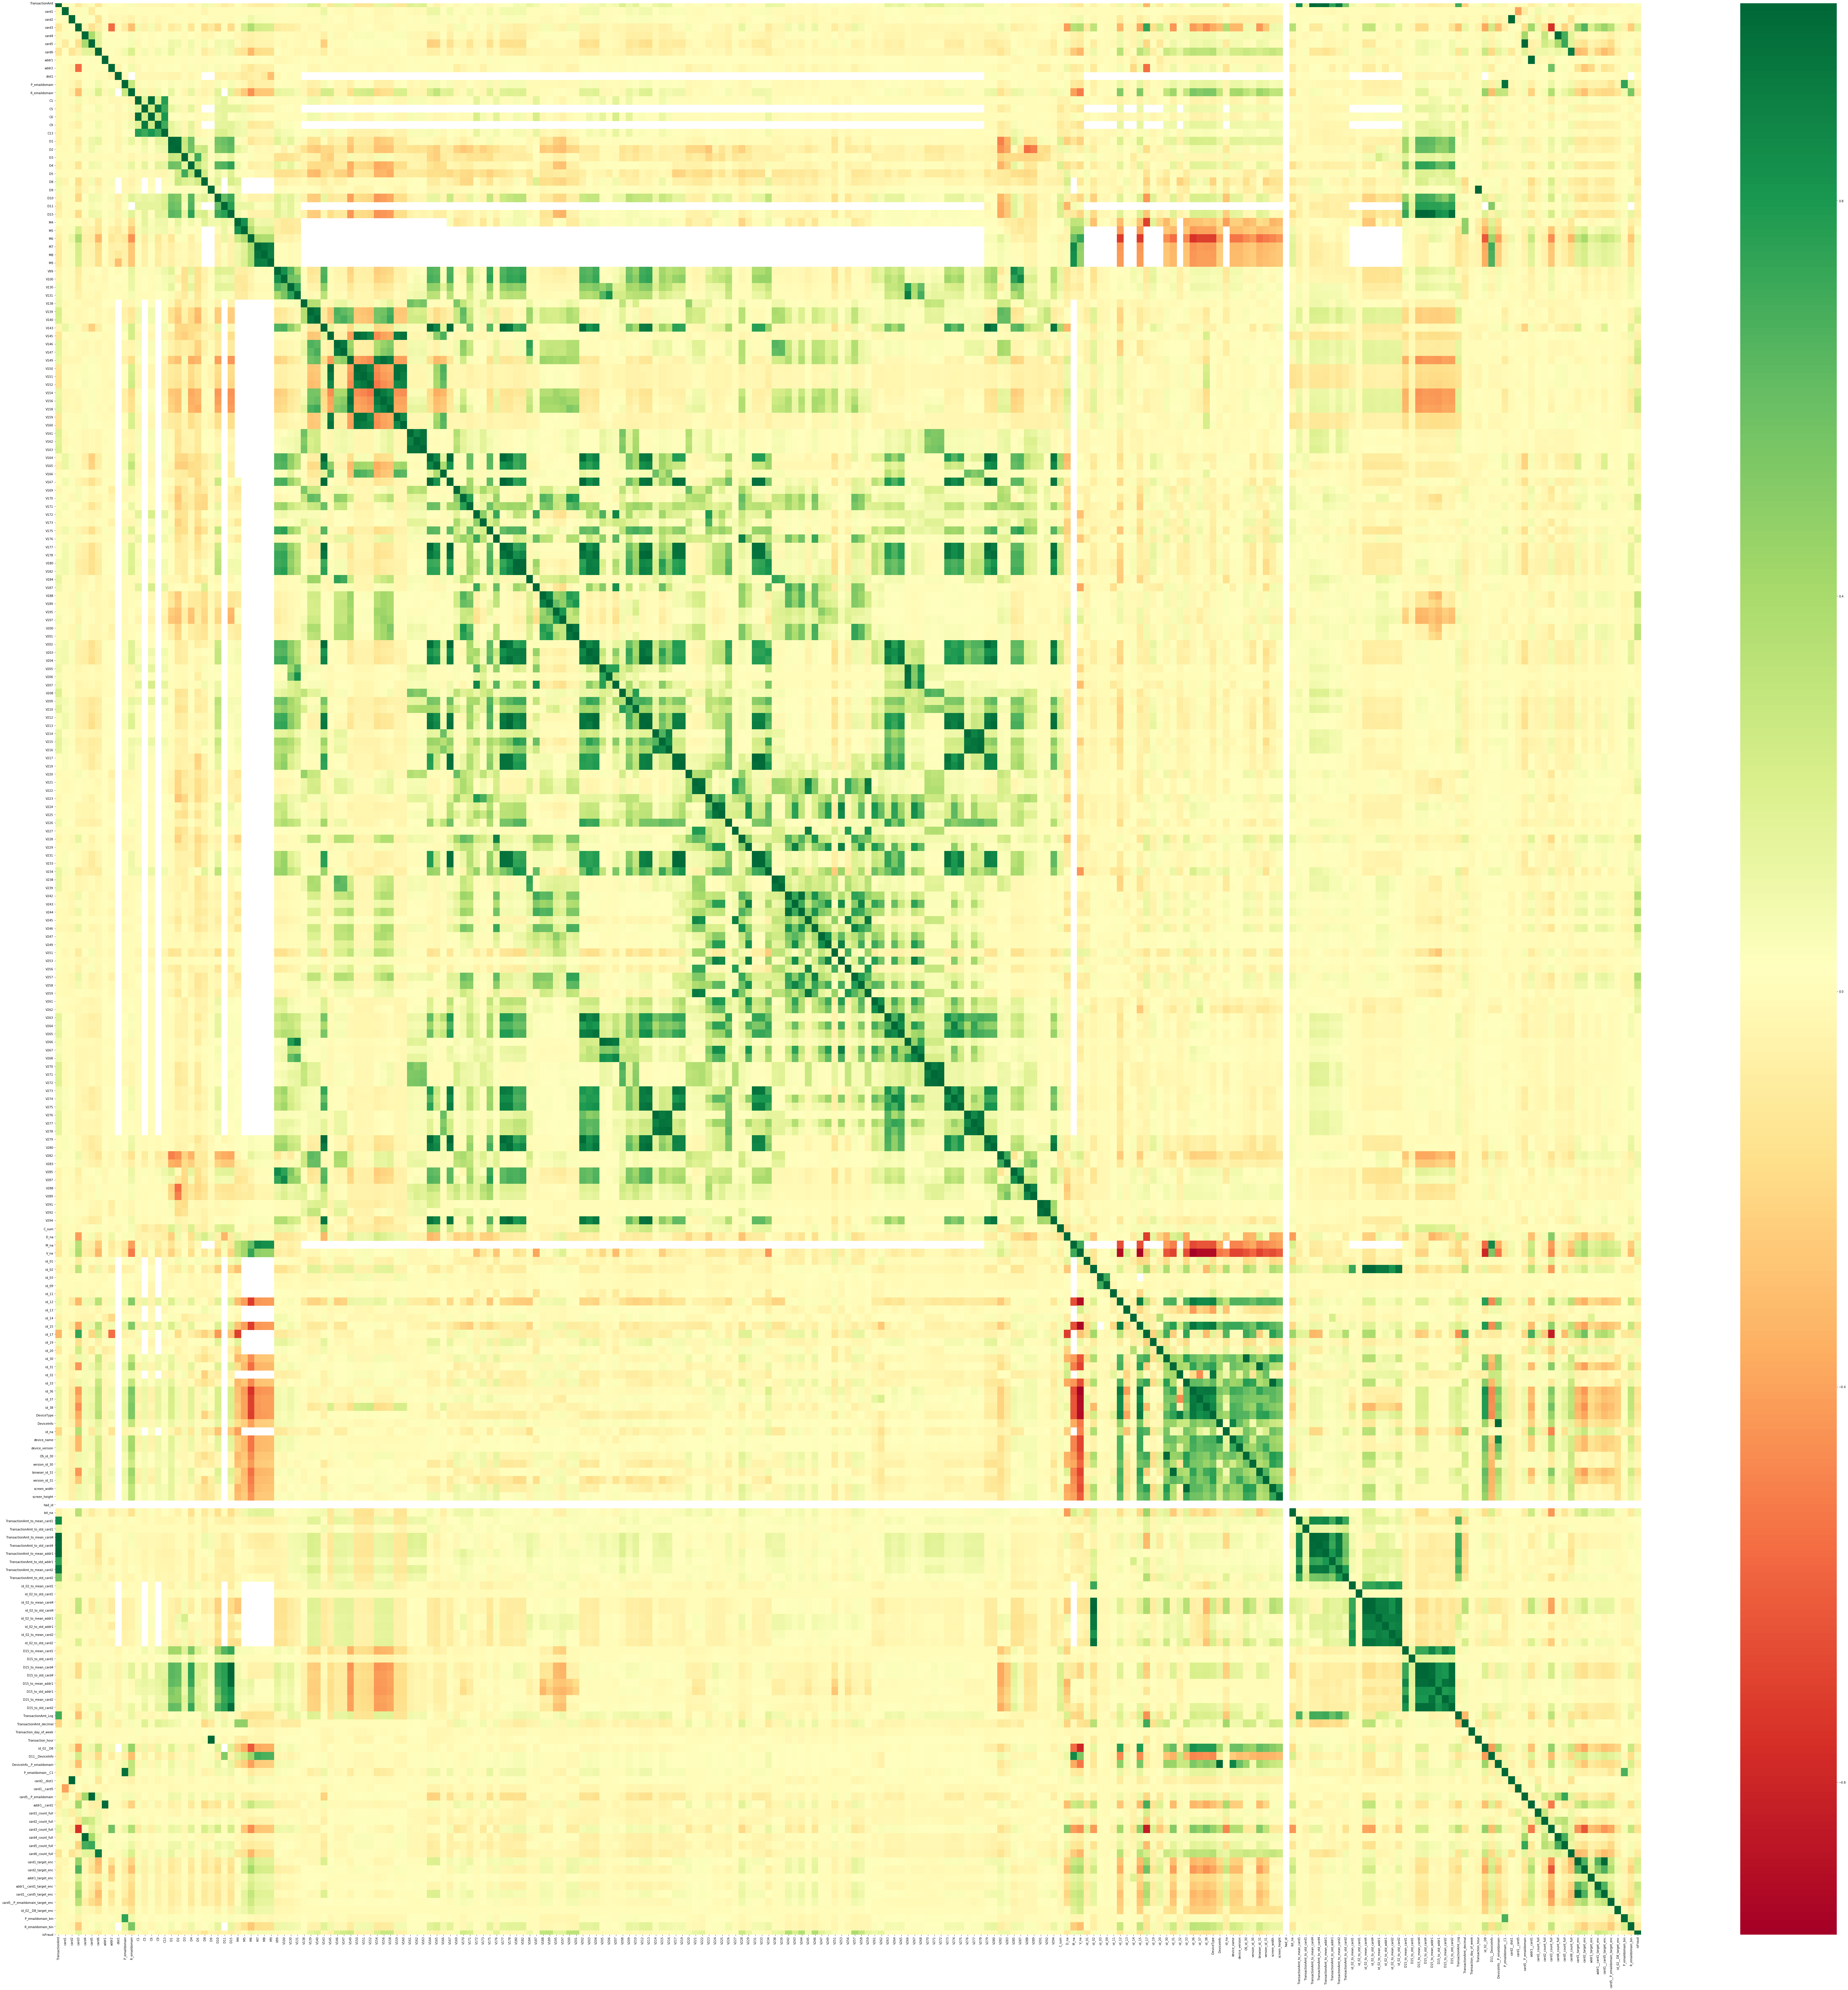

In [30]:
##Correlation Matrix with Heatmap
import seaborn as sns
#get correlations of each features in dataset
X_train['isFraud'] = y_train

corrmat = X_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(120,120))
#plot heat map
g=sns.heatmap(X_train[top_corr_features].corr(),annot=False,cmap="RdYlGn")

In [32]:

sub = pd.DataFrame(columns=['TransactionID','isFraud'])
sub['TransactionID'] = test_trans_id
sub['isFraud'] = y_result
sub




sub.to_csv("submissio56th-updated.csv",index=False)

sum(y_result>0.1)


19485

In [33]:
19573/50000

0.39146